In [1]:
!pip install timm

In [2]:
# !apt-get install unrar
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
# !unrar x UCF50.rar
# # !rm -fr UCF50.rar

# PATH_DATASET_DIR = "/kaggle/working/UCF50"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import timm

from torch import nn
from tqdm import tqdm
import random
from glob import glob
import cv2

# Dataset

In [4]:
#  to use dataset from kaggle
PATH_DATASET_DIR = "/kaggle/input/ucf50-action-recognition-dataset/UCF50"
HEIGHT, WIDTH = 240, 320
SEQUENCE_LENGTH = 20

videos = glob(f"{PATH_DATASET_DIR}/**/*.avi")
labels = [path.replace(f"{PATH_DATASET_DIR}/", "") for path in glob(f"{PATH_DATASET_DIR}/**")]

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

class VideoDataset(Dataset):
    
    def __init__(self, video_paths, transform=None, num_videos=None, num_frames=None):
        self.video_paths = video_paths
        self.transform = transform
        self.lab2idx = {}
        
        if num_videos is not None:
            labels = set([path.split("/")[-2] for path in video_paths])
            self.lab2idx = { w : i for i, w in enumerate(labels) } 
            buffer = []
            for label in labels:
                videos = []
                for path in video_paths:
                    if label in path:
                        videos.append(path)
                videos = np.random.choice(videos, num_videos)
                buffer.extend(videos)
            self.paths = buffer
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        video_path = self.paths[idx]
        label = video_path.split("/")[-2]
        frames = self.read_video(video_path)
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        else:
            frames = torch.stack(frames)
        return frames, self.lab2idx[label]
    
    def read_video(self, video_path):
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        window = max(int(frames_count/SEQUENCE_LENGTH), 1)
        
        for i in range(SEQUENCE_LENGTH):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * window)
            ret, frame = cap.read()
            if not ret:
                break
            fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            
        cap.release()
        return np.array(frames)

In [7]:
dataset = VideoDataset(videos, transform, 100)

In [8]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

torch.manual_seed(42)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [9]:
len(dataset)

5000

In [10]:
len(train_dataset)

3500

In [11]:
train_dataset.dataset[0][0].shape

torch.Size([20, 3, 240, 240])

# Evaluate function

In [12]:
def evaluate(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
    
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
    
    model = model.to(device)

    if weights:
        model.load_state_dict(torch.load(weights))
    
    with torch.no_grad():
        model.eval()
        val_correct = 0
        val_total = len(val_data)*val_data.batch_size
        running_loss = 0.
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for data_batch, label_batch in val_data:
            
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)
            output_batch = model(data_batch)
            loss = loss_fn(output_batch, label_batch.long())
            running_loss += loss.item()

            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            val_correct += (label_batch == predicted_labels).sum().item()
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/val_total
        return val_loss, val_acc


# Train function

In [13]:
def train(model, train_data, val_data, loss_fn, optimizer, epochs, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', scheduler = None):

    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')        

    if save_best_weights_path: 
        best_loss, _ = evaluate(model, val_data, device = device, loss_fn = loss_fn, verbose = 1)  

    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)

    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1    
    
    ## History
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }
        
    # add model to device
    model = model.to(device)
    
    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):

        running_loss = 0.
        train_correct = 0
        train_total = steps_per_epoch*train_data.batch_size
        

        model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100): 
            
            img_batch, label_batch = next(iterator)
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            

            optimizer.zero_grad()
            

            output_batch = model(img_batch)
            

            loss = loss_fn(output_batch, label_batch.long())
            

            loss.backward()
            

            optimizer.step()

            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            train_correct += (label_batch == predicted_labels).sum().item()
                

            running_loss += loss.item()
                
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
        torch.cuda.empty_cache()
    
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct/train_total
        
        if scheduler:
            scheduler.step(train_loss)
        
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_accuracy))
        
        if val_data is not None: 
            val_loss, val_acc = evaluate(model, val_data, device = device, loss_fn = loss_fn)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')

            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            history['val_loss'].append(float(val_loss))
            history['val_acc'].append(float(val_acc))
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')
    if save_last_weights_path:  
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model, history


# Conv + LSTM 
<!-- ![](https://www.researchgate.net/publication/334729124/figure/fig2/AS:785436423241728@1564274044276/Conv-LSTM-neural-network-structure-is-composed-of-three-main-functional-layers.png) -->
![](https://www.kaggle.com/code/muayad/ucf101/__results___files/__results___17_0.png)

In [14]:
def list_to_stack(xs):
    xs=torch.stack(xs, dim=1)
    return xs

In [15]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

In [16]:
# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes, num_parall_conv = 10, num_lstm_layers = 2):
#         super().__init__()
        
#         self.conv_parall = []
#         for slice_indx in range(0, num_parall_conv, 1):
#             self.conv_parall.append(self.add_conv_layer(slice_indx))
#         self.conv_parall = nn.Sequential(*self.conv_parall)
# #         self.backbone = timm.create_model(backbone_name, pretrained = True, features_only = True)
        
#         target_shape=(10,32*48*50)
#         self.target_shape = target_shape
#         self.to_serial = nn.Sequential(LambdaLayer(list_to_stack), 
#                                  nn.Conv3d(in_channels=3, out_channels=30, kernel_size=3, padding='same'),
#                                  nn.BatchNorm3d(num_features=30, momentum=0.8))
        
#         self.out = nn.Sequential(nn.Linear(in_features=100, out_features=50,bias=True), nn.Softmax())
#         self.adap = nn.AdaptiveAvgPool2d((2,2))
#         self.gru = nn.Sequential(nn.GRU(input_size=25, hidden_size=50, num_layers=2, dropout=0.5))
#         self.fc = nn.Sequential(nn.Linear(in_features=300, out_features=100,bias=True), nn.ReLU())
#         # self.lstm = nn.LSTM(2048, hidden_size, num_lstm_layers, batch_first = True)
        
# #         self.fc = nn.Linear(hidden_size, num_classes)
    
    
#     def add_conv_layer(self, slice_indx):
#         conv_layer = nn.Sequential(LambdaLayer(lambda x: x[:, slice_indx]), 
#                                     nn.Conv2d(in_channels=3,out_channels=20, kernel_size=3, padding='same'),
#                                     nn.BatchNorm2d(num_features=20, momentum=0.8),
#                                     nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding='same'),
# #                                     nn.BatchNorm2d(num_features=240*240, momentum=0.8),
#                                     nn.MaxPool2d(kernel_size=2),
                                    
#                                     nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, padding='same'),
#                                     nn.BatchNorm2d(num_features=30, momentum=0.8),
#                                     nn.MaxPool2d(kernel_size=2),
#                                     nn.Conv2d(in_channels=30, out_channels=30, kernel_size=3, padding='same'),
#                                    )
#         return conv_layer
    
    
#     def forward(self, x):
#         'x: batch, num_frames, channels, height, width'
#         batch, num_frames, channels, height, width = x.shape
#         print(x.shape)
        
#         xs = []
# #         x = torch.reshape(x, (-1, *x.shape[2:]))
#         for i, conv in enumerate(self.conv_parall):
#             xs.append(conv(x))
#         x = torch.ToTensor(xs)
# #         x = self.conv_parall(x)
#         x = self.to_serial(x)
#         x = torch.reshape(x, self.target_shape)
#         x = self.gru(x)
#         x = self.fc(x)
# #         x1,x2,x3,x4,x5 = self.backbone(x)
        
# #         x = self.adap(x3)
        
# #         x = nn.Flatten()(x)
        
# #         x = torch.reshape(x, (batch, num_frames, -1))
        
# #         x, (h_n, c_n) = self.lstm(x)
        
# #         x = h_n[-1, ...]
        
# #         x = self.fc(x)
#         return x

In [17]:
import torch.nn.functional as F

class ClassificationModel(nn.Module):
    def __init__(self, n_conv=4, num_classes=10):
        super(ClassificationModel, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.n_conv = n_conv
        for i in range(n_conv):
            conv_layer = nn.Sequential(
                LambdaLayer(lambda x: x[:, i]),
                nn.Conv2d(3, 20, kernel_size=3, padding=1),
                nn.BatchNorm2d(20, momentum=0.8),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(20, 30, kernel_size=3, padding=1),
                nn.BatchNorm2d(30, momentum=0.8),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(30, 30, kernel_size=3, padding=1)
            )
            self.conv_layers.append(conv_layer)
#                         self.conv_layers.append(module=conv_layer, name = f'conv2d {i}')

        self.conv3d = nn.Conv3d(n_conv, 30, kernel_size=3, padding=1)
        self.batchnorm = nn.BatchNorm3d(30, momentum=0.8)
        self.gru1 = nn.GRU(30 * 30 * 60 * 60 , 25, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(50, 50, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, num_classes)
    
    def forward(self, x):
        inp = torch.zeros(x.shape, device=device)
        num_frames, batch, channels, height, width = x.shape

        xs =[]
#         print(num_frames, batch, channels, height, width)
#         print(self.conv_layers[5])
        for slice_indx in range(0, self.n_conv, 1):
#             x_slice = LambdaLayer(lambda x: x[:, slice_indx])(inp)
#             x_slice = x[:, slice_indx, :, :, :]
            x_slice = self.conv_layers[slice_indx](x)
            xs.append(x_slice)
        
        t = torch.stack(xs, dim=1)
        t = self.conv3d(t)
        t = self.batchnorm(t)
        t = t.view(t.size(0), -1)
#         return t
        t, _ = self.gru1(t)
        t, _ = self.gru2(t)
        t = self.fc1(t)
        out = self.fc2(t)
        out = F.softmax(out, dim=1)
        return out

# Visualize history

In [18]:
def visualize_history(history, metrics = ['acc', 'loss']):   
    
    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

# Parameters

In [19]:
# classesIdx = '/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt'
# trainTest_dir = '/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist'
mode = 'train'
last_weights = 'last_weights.pt'
best_weights = 'best_weights.pt'

num_classes = 50
batch_size = 4
num_frames = SEQUENCE_LENGTH
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_workers = os.cpu_count()
data_entity_size = train_dataset.dataset[0][0].shape
hidden_size = 128
num_lstm_layers = 2

# Transform and train dataloader

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)

# Create model

In [21]:
torch.cuda.empty_cache()

model = ClassificationModel(n_conv=4, num_classes=num_classes)

In [22]:
# !pip install torch-summary
# !pip install torchviz

In [23]:
# from torchsummary import summary


# torch.cuda.empty_cache()

# summary(model, (batch_size, data_entity_size[1], data_entity_size[2], data_entity_size[3]))

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'min', patience = 3, verbose = 1)

In [25]:
# img_batch, label_batch =  next(iter(train_dataloader))
# torch.cuda.empty_cache()

# torch.onnx.export(model.to(device), img_batch.to(device), 'iris.onnx', input_names=["features"], output_names=["classes"])

In [26]:
# from torchviz import make_dot

# # train_dataloader.
# # batch = iter(train_dataloader)
# # print(batch)

# torch.cuda.empty_cache()

# img_batch, label_batch =  next(iter(train_dataloader))
# yhat = model(img_batch.to(device)) # Give dummy batch to forward().

# # yhat = model(train_dataloader.__getitem__(0).to(device)) # Give dummy batch to forward().

# # yhat = model(train_dataset.dataset.to(device)) # Give dummy batch to forward().

# make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

# Train model

In [27]:
torch.cuda.empty_cache()

model, history = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs = 50,
              save_last_weights_path = last_weights, save_best_weights_path = best_weights,
              device = device, scheduler = scheduler)

epoch: 1/50: 100%|████████████████████████████████████████████████| 875/875 [04:44<00:00,  3.08it/s]


epoch: 1, train_accuracy:  0.02, loss:  3.912, val_accuracy:  0.03, val_loss: 3.912
Saved successfully best weights to: best_weights.pt


epoch: 2/50: 100%|████████████████████████████████████████████████| 875/875 [04:41<00:00,  3.11it/s]


epoch: 2, train_accuracy:  0.03, loss:  3.912, val_accuracy:  0.03, val_loss: 3.912
Saved successfully best weights to: best_weights.pt


epoch: 3/50: 100%|████████████████████████████████████████████████| 875/875 [04:41<00:00,  3.11it/s]


epoch: 3, train_accuracy:  0.02, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912
Saved successfully best weights to: best_weights.pt


epoch: 4/50: 100%|████████████████████████████████████████████████| 875/875 [04:39<00:00,  3.13it/s]


epoch: 4, train_accuracy:  0.02, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 5/50: 100%|████████████████████████████████████████████████| 875/875 [04:40<00:00,  3.12it/s]


epoch: 5, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.911
Saved successfully best weights to: best_weights.pt


epoch: 6/50: 100%|████████████████████████████████████████████████| 875/875 [04:38<00:00,  3.14it/s]


epoch: 6, train_accuracy:  0.03, loss:  3.910, val_accuracy:  0.02, val_loss: 3.911
Saved successfully best weights to: best_weights.pt


epoch: 7/50: 100%|████████████████████████████████████████████████| 875/875 [04:39<00:00,  3.13it/s]


epoch: 7, train_accuracy:  0.02, loss:  3.910, val_accuracy:  0.03, val_loss: 3.911


epoch: 8/50: 100%|████████████████████████████████████████████████| 875/875 [04:41<00:00,  3.10it/s]


epoch: 8, train_accuracy:  0.02, loss:  3.910, val_accuracy:  0.03, val_loss: 3.911


epoch: 9/50: 100%|████████████████████████████████████████████████| 875/875 [04:40<00:00,  3.12it/s]


epoch: 9, train_accuracy:  0.03, loss:  3.910, val_accuracy:  0.03, val_loss: 3.911
Saved successfully best weights to: best_weights.pt


epoch: 10/50: 100%|███████████████████████████████████████████████| 875/875 [04:40<00:00,  3.12it/s]


epoch: 10, train_accuracy:  0.03, loss:  3.910, val_accuracy:  0.03, val_loss: 3.911


epoch: 11/50: 100%|███████████████████████████████████████████████| 875/875 [04:42<00:00,  3.10it/s]

Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


epoch: 11, train_accuracy:  0.03, loss:  3.910, val_accuracy:  0.03, val_loss: 3.912


epoch: 12/50: 100%|███████████████████████████████████████████████| 875/875 [04:40<00:00,  3.12it/s]


epoch: 12, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 13/50: 100%|███████████████████████████████████████████████| 875/875 [04:41<00:00,  3.11it/s]


epoch: 13, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 14/50: 100%|███████████████████████████████████████████████| 875/875 [04:42<00:00,  3.10it/s]


epoch: 14, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 15/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.07it/s]

Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.


epoch: 15, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 16/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.07it/s]


epoch: 16, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 17/50: 100%|███████████████████████████████████████████████| 875/875 [04:46<00:00,  3.05it/s]


epoch: 17, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 18/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.08it/s]


epoch: 18, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 19/50: 100%|███████████████████████████████████████████████| 875/875 [04:43<00:00,  3.09it/s]

Epoch 00019: reducing learning rate of group 0 to 1.0000e-07.


epoch: 19, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 20/50: 100%|███████████████████████████████████████████████| 875/875 [04:46<00:00,  3.06it/s]


epoch: 20, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 21/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.08it/s]


epoch: 21, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 22/50: 100%|███████████████████████████████████████████████| 875/875 [04:46<00:00,  3.05it/s]


epoch: 22, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 23/50: 100%|███████████████████████████████████████████████| 875/875 [04:47<00:00,  3.04it/s]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-08.


epoch: 23, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 24/50: 100%|███████████████████████████████████████████████| 875/875 [04:47<00:00,  3.04it/s]


epoch: 24, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 25/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.07it/s]


epoch: 25, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 26/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.06it/s]


epoch: 26, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 27/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.06it/s]


epoch: 27, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 28/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.06it/s]


epoch: 28, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 29/50: 100%|███████████████████████████████████████████████| 875/875 [04:47<00:00,  3.05it/s]


epoch: 29, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 30/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.07it/s]


epoch: 30, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 31/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.07it/s]


epoch: 31, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 32/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.07it/s]


epoch: 32, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 33/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.07it/s]


epoch: 33, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 34/50: 100%|███████████████████████████████████████████████| 875/875 [04:47<00:00,  3.05it/s]


epoch: 34, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 35/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.07it/s]


epoch: 35, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 36/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.07it/s]


epoch: 36, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 37/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.07it/s]


epoch: 37, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 38/50: 100%|███████████████████████████████████████████████| 875/875 [04:46<00:00,  3.05it/s]


epoch: 38, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 39/50: 100%|███████████████████████████████████████████████| 875/875 [04:47<00:00,  3.05it/s]


epoch: 39, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 40/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.06it/s]


epoch: 40, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 41/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.07it/s]


epoch: 41, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 42/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.07it/s]


epoch: 42, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 43/50: 100%|███████████████████████████████████████████████| 875/875 [04:43<00:00,  3.09it/s]


epoch: 43, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 44/50: 100%|███████████████████████████████████████████████| 875/875 [04:49<00:00,  3.03it/s]


epoch: 44, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 45/50: 100%|███████████████████████████████████████████████| 875/875 [04:46<00:00,  3.06it/s]


epoch: 45, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 46/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.07it/s]


epoch: 46, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 47/50: 100%|███████████████████████████████████████████████| 875/875 [04:44<00:00,  3.08it/s]


epoch: 47, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 48/50: 100%|███████████████████████████████████████████████| 875/875 [04:45<00:00,  3.07it/s]


epoch: 48, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 49/50: 100%|███████████████████████████████████████████████| 875/875 [04:43<00:00,  3.09it/s]


epoch: 49, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912


epoch: 50/50: 100%|███████████████████████████████████████████████| 875/875 [04:43<00:00,  3.08it/s]


epoch: 50, train_accuracy:  0.03, loss:  3.911, val_accuracy:  0.03, val_loss: 3.912
Saved successfully last weights to: last_weights.pt


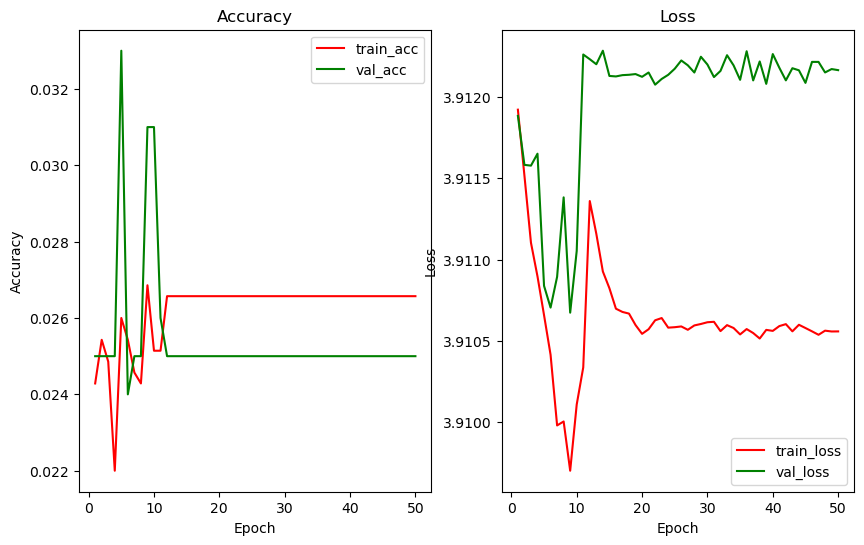

In [28]:
visualize_history(history)

# Transform and test data loader

In [29]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, drop_last = True, num_workers = num_workers)

# Test Model

In [30]:
test_loss, test_acc = evaluate(model, weights = last_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Evaluate: 100%|███████████████████████████████████████████████████| 125/125 [00:36<00:00,  3.44it/s]

Loss:  3.913, Acc:  0.020


In [31]:
test_loss, test_acc = evaluate(model, weights = best_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Evaluate: 100%|███████████████████████████████████████████████████| 125/125 [00:35<00:00,  3.47it/s]

Loss:  3.914, Acc:  0.022
